In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import Model_3

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([

                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1


cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)


torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)


train_loader = torch.utils.data.DataLoader(train, **dataloader_args)


test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


In [5]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_3().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
         MaxPool2d-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 10, 10, 10]           1,440
             ReLU-10           [-1, 10, 10, 10]               0
      BatchNorm2d-11           [-1, 10, 10, 10]              20
          Dropout-12           [-1, 10, 10, 10]               0
           Conv2d-13             [-1, 18, 8, 8]           1,620
             ReLU-14             [-

In [6]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [7]:
from torch.optim.lr_scheduler import StepLR
model =  Model_3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.038605909794569016 Batch_id=937 Accuracy=94.57: 100%|██████████| 938/938 [00:39<00:00, 24.05it/s]



Test set: Average loss: 0.0391, Accuracy: 9887/10000 (98.87%)

EPOCH: 1


Loss=0.02093387022614479 Batch_id=937 Accuracy=97.97: 100%|██████████| 938/938 [00:37<00:00, 25.17it/s]  



Test set: Average loss: 0.0274, Accuracy: 9908/10000 (99.08%)

EPOCH: 2


Loss=0.02477218583226204 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [00:37<00:00, 24.92it/s]  



Test set: Average loss: 0.0258, Accuracy: 9914/10000 (99.14%)

EPOCH: 3


Loss=0.004539443179965019 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [00:37<00:00, 24.74it/s] 



Test set: Average loss: 0.0236, Accuracy: 9925/10000 (99.25%)

EPOCH: 4


Loss=0.006478548049926758 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:36<00:00, 25.60it/s] 



Test set: Average loss: 0.0269, Accuracy: 9917/10000 (99.17%)

EPOCH: 5


Loss=0.13754583895206451 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:36<00:00, 25.51it/s]  



Test set: Average loss: 0.0179, Accuracy: 9943/10000 (99.43%)

EPOCH: 6


Loss=0.010010011494159698 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:37<00:00, 25.07it/s] 



Test set: Average loss: 0.0185, Accuracy: 9940/10000 (99.40%)

EPOCH: 7


Loss=0.005595657043159008 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:45<00:00, 20.71it/s] 



Test set: Average loss: 0.0171, Accuracy: 9941/10000 (99.41%)

EPOCH: 8


Loss=0.0012456077383831143 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:38<00:00, 24.40it/s]



Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

EPOCH: 9


Loss=0.04374314844608307 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:37<00:00, 25.26it/s]  



Test set: Average loss: 0.0165, Accuracy: 9946/10000 (99.46%)

EPOCH: 10


Loss=0.0018472333904355764 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:37<00:00, 25.33it/s]



Test set: Average loss: 0.0166, Accuracy: 9952/10000 (99.52%)

EPOCH: 11


Loss=0.033044666051864624 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:37<00:00, 25.29it/s] 



Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

EPOCH: 12


Loss=0.07103408873081207 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:37<00:00, 25.25it/s]  



Test set: Average loss: 0.0167, Accuracy: 9945/10000 (99.45%)

EPOCH: 13


Loss=0.048950906842947006 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:37<00:00, 25.23it/s] 



Test set: Average loss: 0.0169, Accuracy: 9944/10000 (99.44%)

EPOCH: 14


Loss=0.0011239639716222882 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:36<00:00, 25.48it/s]



Test set: Average loss: 0.0171, Accuracy: 9945/10000 (99.45%)



In [8]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

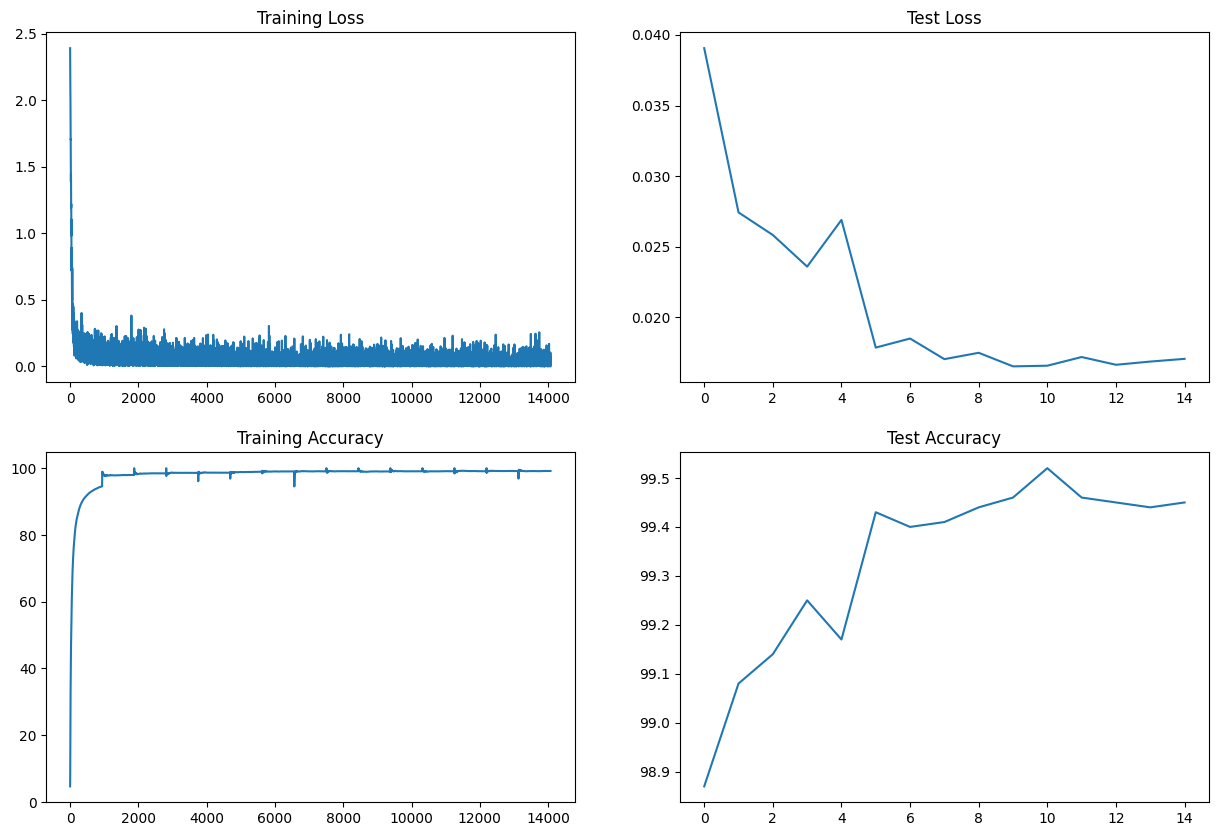

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target:
1) Added GAP
2) Adjusted location of Dropout, Batch-norm and max pool
3) Reduce the Dropout value to 0.10
4) Added scheduler
5) In optimizer changed Lr to 0.02 for batter result
6) fix the location of max pool


## Results:
1) Parameters: 7864
Best Training Accuracy: 99.16
Best Test Accuracy: 99.52

## Analysis:
1) With proper adjustment in LR and schduler we got upto 99.52(EPOCH 10) test accuracy, final test accuracy 99.45(EPOCH 15)
2) The model is under fitting.
3) We dont need to use drop out in all layer. 
Need to multiple changes to get proper location to use it.